### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Наши новости

In [4]:
news = pd.read_csv("/content/drive/MyDrive/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [32]:
users = pd.read_csv("/content/drive/MyDrive/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [7]:
!pip install razdel

In [9]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 8.2 MB 23.3 MB/s 


In [10]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [15]:
with open('/content/drive/MyDrive/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [16]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [17]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 24.8 s, sys: 1.28 s, total: 26 s
Wall time: 26.1 s


In [18]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 33s, sys: 810 ms, total: 4min 33s
Wall time: 4min 34s


А теперь в 3 строчки обучим нашу модель

In [19]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [20]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [21]:
common_dictionary[10]

'ватутин'

In [22]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 3),
  (90, 2),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [23]:
from gensim.models import LdaModel

In [24]:
LdaModel?

In [25]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 55.5 s, sys: 27 s, total: 1min 22s
Wall time: 52.9 s


Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [26]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.0823622),
 (5, 0.030040003),
 (11, 0.112467706),
 (17, 0.12532629),
 (20, 0.059252046),
 (21, 0.18954444),
 (23, 0.06016522),
 (24, 0.3242567)]

In [27]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: россия российский украина газ вопрос развитие уровень
topic_1: исследование вода взрыв солнечный лаборатория вещество расследование
topic_2: территория россия российский министерство сторона общество спутник
topic_3: экономика экономический животное статья санкция внутренний испытание
topic_4: сша проверка нефть операция государство рак китай
topic_5: мозг луна клетка заболевание экипаж пассажир тело
topic_6: земля район северный парламент законопроект потребление ресурс
topic_7: рубль млн цена тыс составить рост фонд
topic_8: эксперимент сотрудник статья задержать египет чиновник обнаружить
topic_9: банк писать рынок турист nn руб россия
topic_10: nn украина глава уголовный рф обнаружить россия
topic_11: журнал планета обращение университет нафтогаз зонд стена
topic_12: сша самолёт американский космический ракета полёт корабль
topic_13: область nn движение здание сотрудник газета час
topic_14: топливо белоруссия перевод растение атмосферный польша сосед
topic_15: военный арми

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [28]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [29]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.50518,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.361361,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.094865,0.031536
1,4896,0.00000,0.344640,0.000000,0.0,0.0,0.000000,0.0,0.0,0.08575,0.000000,0.052873,0.000000,0.0,0.0,0.000000,0.053186,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.225696,0.219319
2,4897,0.00000,0.000000,0.082363,0.0,0.0,0.030039,0.0,0.0,0.00000,0.000000,0.000000,0.112501,0.0,0.0,0.000000,0.000000,0.000000,0.125337,0.0,0.0,0.05925,0.189542,0.0,0.060119,0.324263
3,4898,0.06028,0.014618,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.040232,0.000000,0.209251,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.666095,0.000000
4,4899,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.044373,0.341300,0.000000,0.0,0.0,0.000000,0.000000,0.590544,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [33]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [34]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [35]:
doc_dict[293622]

array([0.07663638, 0.        , 0.13481449, 0.        , 0.01725223,
       0.        , 0.        , 0.        , 0.036734  , 0.06739195,
       0.02379541, 0.04855581, 0.        , 0.        , 0.        ,
       0.01676527, 0.        , 0.03778676, 0.0584221 , 0.29472816,
       0.        , 0.01393726, 0.04270516, 0.0350622 , 0.09111176])

### Задание 2-3

Задание 2<br>
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

Задание 3 <br>
Повторить п.2, но используя уже не медиану, а max

In [36]:
def get_user_embedding(user_articles_list, method='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if method == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif method == 'median':
        user_vector = np.median(user_vector, 0)
    else:
        user_vector = np.max(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [37]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'mean'), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.032706,0.033329,0.076398,0.031898,0.018392,0.001791,0.000000,0.014791,0.071724,0.057030,0.102388,0.063294,0.00000,0.126011,0.000000,0.002794,0.012856,0.024862,0.039094,0.071304,0.008831,0.026518,0.022802,0.111857,0.036249
1,u108690,0.224023,0.015654,0.053848,0.007293,0.015696,0.015168,0.004005,0.040222,0.027945,0.034096,0.158994,0.003147,0.06802,0.068833,0.005971,0.015954,0.054116,0.068730,0.022080,0.036523,0.000000,0.006481,0.017651,0.015970,0.000000
2,u108339,0.106740,0.044006,0.038829,0.005953,0.111682,0.077234,0.029356,0.015599,0.042343,0.044708,0.189470,0.008032,0.00598,0.072763,0.008242,0.018166,0.014373,0.023996,0.042556,0.006625,0.000000,0.014078,0.010687,0.027109,0.020906


In [38]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'median'), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.039647,0.0,0.000000,0.000000,0.000000,0.000000,0.049860,0.074735,0.052515,0.0,0.0,0.035839,0.0,0.000000,0.000000,0.018893,0.018159,0.007067,0.0,0.017834,0.008155,0.035207,0.000000
1,u108690,0.207581,0.000000,0.020851,0.0,0.017892,0.005091,0.000000,0.000000,0.000000,0.030770,0.134569,0.0,0.0,0.036135,0.0,0.000000,0.017328,0.038558,0.009184,0.019665,0.0,0.005072,0.008770,0.012865,0.000000
2,u108339,0.114286,0.009531,0.017285,0.0,0.017746,0.016958,0.015435,0.009712,0.043816,0.031754,0.163828,0.0,0.0,0.059542,0.0,0.009627,0.012852,0.005940,0.044497,0.000000,0.0,0.005145,0.000000,0.018053,0.011617


In [39]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, 'max'), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.119598,0.199976,0.244280,0.106642,0.093103,0.010746,0.000000,0.088745,0.218623,0.109763,0.356006,0.331208,0.000000,0.597239,0.000000,0.016765,0.061088,0.071635,0.139822,0.294728,0.052986,0.061735,0.077798,0.496112,0.126383
1,u108690,0.468581,0.093926,0.197125,0.022339,0.029984,0.048140,0.013663,0.173748,0.100027,0.084218,0.377930,0.018881,0.353217,0.248161,0.035827,0.061662,0.189681,0.271100,0.062021,0.100801,0.000000,0.016619,0.058179,0.038730,0.000000
2,u108339,0.151860,0.194983,0.114507,0.018737,0.334368,0.261911,0.102582,0.048347,0.089749,0.104482,0.430606,0.029665,0.025782,0.158594,0.032434,0.064704,0.037225,0.083893,0.080768,0.039748,0.000000,0.046952,0.052583,0.098358,0.082103


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [40]:
target = pd.read_csv("/content/drive/MyDrive/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [42]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.032706,0.033329,0.076398,0.031898,0.018392,0.001791,0.000000,0.014791,0.071724,0.057030,0.102388,0.063294,0.00000,0.126011,0.000000,0.002794,0.012856,0.024862,0.039094,0.071304,0.008831,0.026518,0.022802,0.111857,0.036249,0
1,u108690,0.224023,0.015654,0.053848,0.007293,0.015696,0.015168,0.004005,0.040222,0.027945,0.034096,0.158994,0.003147,0.06802,0.068833,0.005971,0.015954,0.054116,0.068730,0.022080,0.036523,0.000000,0.006481,0.017651,0.015970,0.000000,1
2,u108339,0.106740,0.044006,0.038829,0.005953,0.111682,0.077234,0.029356,0.015599,0.042343,0.044708,0.189470,0.008032,0.00598,0.072763,0.008242,0.018166,0.014373,0.023996,0.042556,0.006625,0.000000,0.014078,0.010687,0.027109,0.020906,1


In [43]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.039647,0.0,0.000000,0.000000,0.000000,0.000000,0.049860,0.074735,0.052515,0.0,0.0,0.035839,0.0,0.000000,0.000000,0.018893,0.018159,0.007067,0.0,0.017834,0.008155,0.035207,0.000000,0
1,u108690,0.207581,0.000000,0.020851,0.0,0.017892,0.005091,0.000000,0.000000,0.000000,0.030770,0.134569,0.0,0.0,0.036135,0.0,0.000000,0.017328,0.038558,0.009184,0.019665,0.0,0.005072,0.008770,0.012865,0.000000,1
2,u108339,0.114286,0.009531,0.017285,0.0,0.017746,0.016958,0.015435,0.009712,0.043816,0.031754,0.163828,0.0,0.0,0.059542,0.0,0.009627,0.012852,0.005940,0.044497,0.000000,0.0,0.005145,0.000000,0.018053,0.011617,1


In [47]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.119598,0.199976,0.244280,0.106642,0.093103,0.010746,0.000000,0.088745,0.218623,0.109763,0.356006,0.331208,0.000000,0.597239,0.000000,0.016765,0.061088,0.071635,0.139822,0.294728,0.052986,0.061735,0.077798,0.496112,0.126383,0
1,u108690,0.468581,0.093926,0.197125,0.022339,0.029984,0.048140,0.013663,0.173748,0.100027,0.084218,0.377930,0.018881,0.353217,0.248161,0.035827,0.061662,0.189681,0.271100,0.062021,0.100801,0.000000,0.016619,0.058179,0.038730,0.000000,1
2,u108339,0.151860,0.194983,0.114507,0.018737,0.334368,0.261911,0.102582,0.048347,0.089749,0.104482,0.430606,0.029665,0.025782,0.158594,0.032434,0.064704,0.037225,0.083893,0.080768,0.039748,0.000000,0.046952,0.052583,0.098358,0.082103,1


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
#разделим данные на train/test
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(
    X_median[['topic_{}'.format(i) for i in range(25)]], X_median['churn'], random_state=0)

X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(
    X_max[['topic_{}'.format(i) for i in range(25)]], X_max['churn'], random_state=0)

In [49]:
logreg_mean = LogisticRegression()
logreg_median = LogisticRegression()
logreg_max = LogisticRegression()
#обучим 
logreg_mean.fit(X_train_mean, y_train_mean)
logreg_median.fit(X_train_median, y_train_median)
logreg_max.fit(X_train_max, y_train_max)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
#наши прогнозы для тестовой выборки
preds_mean = logreg_mean.predict_proba(X_test_mean)[:, 1]
print(preds_mean[:10])

preds_median = logreg_median.predict_proba(X_test_median)[:, 1]
print(preds_median[:10])

preds_max = logreg_max.predict_proba(X_test_max)[:, 1]
print(preds_max[:10])

[0.06384315 0.16457902 0.22509907 0.20905185 0.22108403 0.1015902
 0.22231015 0.05236836 0.06786557 0.15214272]
[0.06535155 0.04276512 0.40971513 0.22242522 0.18454326 0.05252678
 0.41219591 0.05736428 0.085557   0.18411553]
[0.02104197 0.02664145 0.44701308 0.06917922 0.16005715 0.09404454
 0.33110844 0.02378378 0.030022   0.24626772]


In [51]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [52]:
import itertools

In [53]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test_mean, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Method = Mean. Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Method = Median. Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Method = Mean. Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Method = Mean. Best Threshold=0.229497, F-Score=0.620, Precision=0.555, Recall=0.702
Method = Median. Best Threshold=0.245866, F-Score=0.732, Precision=0.703, Recall=0.763
Method = Mean. Best Threshold=0.308007, F-Score=0.755, Precision=0.711, Recall=0.804


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1617  138]
 [  74  171]]


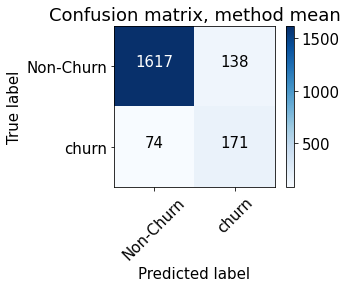

In [55]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_mean, preds_mean>thresholds_mean[ix_mean])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix, method mean')
# plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1676   79]
 [  59  186]]


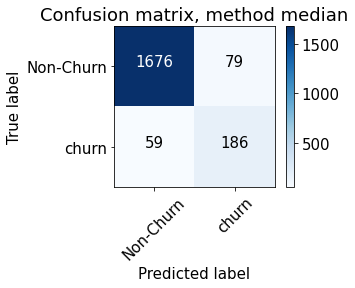

In [56]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_median, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix, method median')
# plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1675   80]
 [  49  196]]


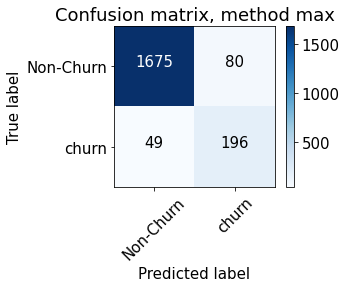

In [59]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_max, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix, method max')
# plt.savefig("conf_matrix.png")
plt.show()

In [60]:
roc_auc_mean = roc_auc_score(y_test_mean, preds_mean)
roc_auc_median = roc_auc_score(y_test_median, preds_median)
roc_auc_max = roc_auc_score(y_test_max, preds_max)

print(f'ROC AUC score for mean method: {roc_auc_mean}')
print(f'ROC AUC score for median method: {roc_auc_median}')
print(f'ROC AUC score for max method: {roc_auc_max}')

ROC AUC score for mean method: 0.9309169137740566
ROC AUC score for median method: 0.9593627536484679
ROC AUC score for max method: 0.9690168033025176


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Задание 5

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [61]:
table = pd.DataFrame(
    {
        'Precision': [precision_mean[ix_mean], precision_median[ix_median], precision_max[ix_max]],
        'Recall': [recall_mean[ix_mean], recall_median[ix_median], recall_max[ix_max]],
        'F1-score': [fscore_mean[ix_mean], fscore_median[ix_median], fscore_max[ix_max]],
        'ROC AUC score': [roc_auc_mean, roc_auc_median, roc_auc_max]
    },
    index=['Mean method', 'Median method', 'Max method']
)

table

,Precision,Recall,F1-score,ROC AUC score
Mean method,0.554839,0.702041,0.619820,0.930917
Median method,0.703008,0.763265,0.731898,0.959363
Max method,0.711191,0.804082,0.754789,0.969017


### Задание 6

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Почти все метрики растут при смене методов расчета user embeddings в следующей последовательности: mean, median, max. При смене median на max Recall падает незначительно. Лучшим методом оказалось взятие максимума. При этом средние и мелкие блоки тем не уменьшаются и не становятся равными нулю. То есть при таком методе подсчета, можно сказать, что модель хорошо улавливает и основные интересы пользователя.

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

#### Дополнительно, библиотеки для анализа текста
1. spacy 
2. natasha
3. nltk